```
This file is part of connectome-manipulator.

SPDX-License-Identifier: Apache-2.0
Copyright (c) 2024 Blue Brain Project/EPFL
```

# Correlation between physiological synapse parameters

By default, during rewiring, physiological synapse parameter values are drawn independently from distributions specified in the `ConnPropsModel`. However, it is known that some physiological parameters are correlated [1, 2, 3]. This example notebook demonstrates how correlations between physiological parameters can be modeled by use of a `ConnPropsModel`.

As a minimal working example, we will create a `ConnPropsModel` containing only a single pathway ("L23_PC" to "L23_PC") and two properties:
- "gsyn" ... Peak conductance (nS)
- "nrrp" ... Number of vesicles in readily releasable pool

We model them as _Gamma_ ("gsyn") and _Poisson_ ("nrrp") distributions respectively, with mean/std values taken from Table S2 of [4]. We will also create another instance of such a `ConnPropsModel`, but including a strong correlation of 0.9 between "gsyn" and "nrrp" as in Eq. 47 of [5]. We will then draw synapse parameter values from both models and visualize the effect of such correlation.

__References:__
1. [Harris K. M., at al. "Dendritic spines of CA 1 pyramidal cells in the rat hippocampus: serial electron microscopy with reference to their biophysical characteristics." Journal of Neuroscience 9.8 (1989): 2982-2997](https://www.jneurosci.org/content/9/8/2982.short).
2. [Schikorski T., et al. "Quantitative fine-structural analysis of olfactory cortical synapses." PNAS 96.7 (1999): 4107-4112](https://www.pnas.org/doi/full/10.1073/pnas.96.7.4107)
3. [Arellano J. I., et al. "Ultrastructure of dendritic spines: correlation between synaptic and spine morphologies." Frontiers in neuroscience 1 (2007): 42](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/neuro.01.1.1.010.2007/full)
4. [Isbister J. B., et al. "Modeling and simulation of neocortical micro-and mesocircuitry. Part II: Physiology and experimentation." bioRxiv (2023): 2023.05.17.541168](https://www.biorxiv.org/content/10.1101/2023.05.17.541168v5).
5. [Chindemi G., et al. "A calcium-based plasticity model for predicting long-term potentiation and depression in the neocortex." Nature Communications 13.1 (2022): 3038](https://www.nature.com/articles/s41467-022-30214-w).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from connectome_manipulator.model_building import model_types

In [2]:
# Create ConnPropsModel instance with parameterization for L23_PC to L23_PC from [Isbister et al. 2023, Tab. S2]
# gsyn ... ~Gamma (1.0 ± 0.5 nS)
# nrrp ... ~Poisson (2.6)

stats_dict = {
    "gsyn": {"L23_PC": {"L23_PC": {"type": "gamma", "mean": 1.0, "std": 0.5, "shared_within": False}}},
    "nrrp": {"L23_PC": {"L23_PC": {"type": "poisson", "mean": 2.6, "shared_within": False}}},
}

model1 = model_types.ConnPropsModel(src_types=["L23_PC"], tgt_types=["L23_PC"], prop_stats=stats_dict)
print(model1)

ConnPropsModel (w/o #syn/conn)
  Connection/synapse property distributions between 1x1 M-types:
  gsyn <gamma>; nrrp <poisson>


In [3]:
# Create another ConnPropsModel instance with correlated properties gsyn and nrrp as in [Chindemi et al. 2022, Eq. 47]
cov_mat = np.array([[1.0, 0.9], [0.9, 1.0]])  # Covariance matrix
cov_dict = {
    "props": ["gsyn", "nrrp"],
    "cov": {"L23_PC": {"L23_PC": cov_mat}}
}

model2 = model_types.ConnPropsModel(src_types=["L23_PC"], tgt_types=["L23_PC"], prop_stats=stats_dict, prop_cov=cov_dict)
print(model2)

ConnPropsModel (w/o #syn/conn)
  Connection/synapse property distributions between 1x1 M-types:
  gsyn <gamma>; nrrp <poisson>
  Correlated properties: gsyn, nrrp


In [4]:
# Draw values from both models
N = 10000
np.random.seed(0)
syn_vals1 = model1.apply(src_type="L23_PC", tgt_type="L23_PC", n_syn=N)
syn_vals2 = model2.apply(src_type="L23_PC", tgt_type="L23_PC", n_syn=N)

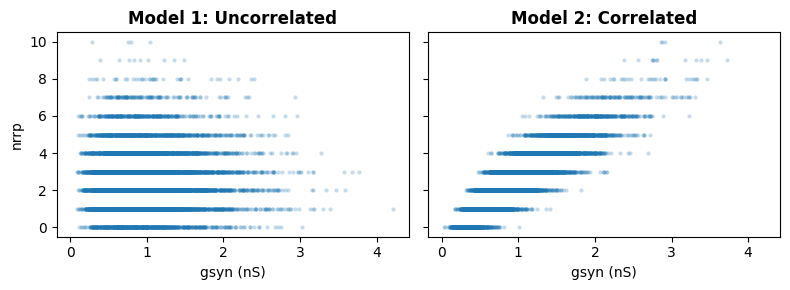

In [5]:
# Visualize synapse parameters
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 3))

ax[0].plot(syn_vals1["gsyn"], syn_vals1["nrrp"], ".", alpha=0.25, markeredgecolor='none')
ax[0].set_xlabel("gsyn (nS)")
ax[0].set_ylabel("nrrp")
ax[0].set_title("Model 1: Uncorrelated", fontweight="bold")

ax[1].plot(syn_vals2["gsyn"], syn_vals2["nrrp"], ".", alpha=0.25, markeredgecolor='none')
ax[1].set_xlabel("gsyn (nS)")
ax[1].set_title("Model 2: Correlated", fontweight="bold")

fig.tight_layout()
fig.show()